# MiniBatchKMeans with RobustScaler

This Code template is for clustering analysis using the Simple MiniBatchKMeans where the scaling method used is Robust Scaler.

### Required Packages

In [ ]:
!pip install plotly

In [3]:
import warnings
import operator
import itertools
import numpy as np 
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

### Initialization

Filepath of CSV file

In [ ]:
#filepath
file_path = ""

List of features which are required for model training

In [5]:
features = []

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df=pd.read_csv(file_path)
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [7]:
X = df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [8]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.

In [9]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
X.head()

Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40

### Data Rescaling
 
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

In [10]:
X_Scaled=RobustScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled, columns = X.columns)
X_Scaled.head()

Age  Annual Income (k$)  Spending Score (1-100)
0 -0.839506           -1.273973               -0.287582
1 -0.740741           -1.273973                0.810458
2 -0.790123           -1.246575               -1.150327
3 -0.641975           -1.246575                0.705882
4 -0.246914           -1.219178               -0.261438

### Silhouette Score 
[Reference](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
* Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
* The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



In [11]:
def SilhoutteScore(X):
    SScore=dict()
    for num_clusters in range(2,11):
        miniBatchKMeans = MiniBatchKMeans(n_clusters=num_clusters,random_state=123).fit(X)
        SScore[num_clusters]=silhouette_score(X, miniBatchKMeans.labels_)
        SScore = dict( sorted(SScore.items(), key=operator.itemgetter(1),reverse=True))
    return SScore

In [12]:
SilhoutteScore(X_Scaled)

{2: 0.32785378084154176,
 3: 0.35306132280657104,
 4: 0.40486530333508214,
 5: 0.4184976389224847,
 6: 0.39108089340545993,
 7: 0.41677527739471787,
 8: 0.40227702879845667,
 9: 0.3758878993248554,
 10: 0.3675507966683222}

### Elbow Method
[Info](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

The Elbow Method is one of the most popular methods to determine this optimal value of k.
We iterate the values of k from 1 to 11 and calculate the distortion or inertia for each value of k in the given range. 
Where Inertia is the sum of squared distances of samples to their closest cluster center.
To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.

In [13]:
def ElbowPlot(X):
    SSE = []
    for i in range(1, 11):
        miniBatchkMeans = MiniBatchKMeans(n_clusters=i,random_state=123).fit(X)
        SSE.append(miniBatchkMeans.inertia_)
    plt.plot(range(1, 11),SSE)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

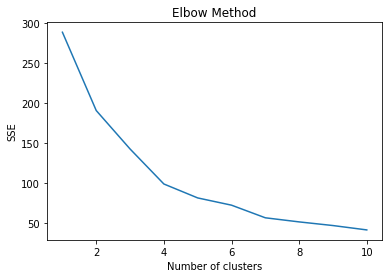

In [14]:
ElbowPlot(X_Scaled)

### Model

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.


#### Tuning Parameters:


**n_clusters: int, default=8** ->
The number of clusters to form as well as the number of centroids to generate.

**init: {‘k-means++’, ‘random’}, callable or array-like of shape (n_clusters, n_features), default=’k-means++’** ->
Method for initialization: ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids. If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers. If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.

**max_iter: int, default=100** ->
Maximum number of iterations over the complete dataset before stopping independently of any early stopping criterion heuristics.

**batch_size: int, default=100** ->
Size of the mini batches.

**verbose: int, default=0** ->
Verbosity mode.

**compute_labels: bool, default=True** ->
Compute label assignment and inertia for the complete dataset once the minibatch optimization has converged in fit.

**random_state: int, RandomState instance or None, default=None** ->
Determines random number generation for centroid initialization and random reassignment. Use an int to make the randomness deterministic. See Glossary.

**tol: float, default=0.0** ->
Control early stopping based on the relative center changes as measured by a smoothed, variance-normalized of the mean center squared position changes. This early stopping heuristics is closer to the one used for the batch variant of the algorithms but induces a slight computational and memory overhead over the inertia heuristic. To disable convergence detection based on normalized center change, set tol to 0.0 (default).

**max_no_improvement: int, default=10** ->
Control early stopping based on the consecutive number of mini batches that does not yield an improvement on the smoothed inertia. To disable convergence detection based on inertia, set max_no_improvement to None.

**init_size: int, default=None** ->
Number of samples to randomly sample for speeding up the initialization (sometimes at the expense of accuracy): the only algorithm is initialized by running a batch KMeans on a random subset of the data. This needs to be larger than n_clusters. If None, init_size= 3 * batch_size.

**n_init: int, default=3** ->
Number of random initializations that are tried. In contrast to KMeans, the algorithm is only run once, using the best of the n_init initializations as measured by inertia.

**reassignment_ratio: float, default=0.01** ->
Control the fraction of the maximum number of counts for a center to be reassigned. A higher value means that low count centers are more easily reassigned, which means that the model will take longer to converge, but should converge in a better clustering.

In [15]:
miniBatchkMeans = MiniBatchKMeans(n_clusters=6, random_state=123)
pred_y = miniBatchkMeans.fit_predict(X_Scaled)

### Cluster Analysis

First, we add the cluster labels from the trained model into the copy of the data frame for cluster analysis/visualization.

In [16]:
ClusterDF = X_Scaled.copy(deep=True)
ClusterDF['ClusterID'] = pred_y
ClusterDF.head()

Age  Annual Income (k$)  Spending Score (1-100)  ClusterID
0 -0.839506           -1.273973               -0.287582          0
1 -0.740741           -1.273973                0.810458          0
2 -0.790123           -1.246575               -1.150327          4
3 -0.641975           -1.246575                0.705882          0
4 -0.246914           -1.219178               -0.261438          4

#### Cluster Records
The below bar graphs show the number of data points in each available cluster.

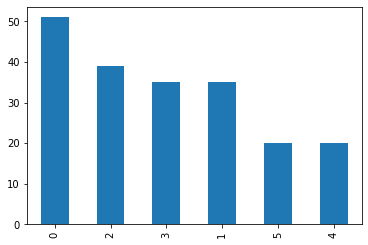

In [17]:
ClusterDF['ClusterID'].value_counts().plot(kind='bar')

#### Cluster Plots
Below written functions get utilized to plot 2-Dimensional and 3-Dimensional cluster plots. Plots include different available clusters along with cluster centroid.

In [18]:
def Plot2DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 2)):
        plt.rcParams["figure.figsize"] = (8,6)
        xi,yi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1])
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            plt.scatter(DFC[i[0]],DFC[i[1]],cmap=plt.cm.Accent,label=j)
        plt.scatter(miniBatchkMeans.cluster_centers_[:,xi],miniBatchkMeans.cluster_centers_[:,yi],marker="^",color="black",label="centroid")
        plt.xlabel(i[0])
        plt.ylabel(i[1])
        plt.legend()
        plt.show()

def Plot3DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig,ax = plt.figure(figsize = (16, 10)),plt.axes(projection ="3d")
        ax.grid(b = True, color ='grey',linestyle ='-.',linewidth = 0.3,alpha = 0.2)
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            ax.scatter3D(DFC[i[0]],DFC[i[1]],DFC[i[2]],alpha = 0.8,cmap=plt.cm.Accent,label=j)
        ax.scatter3D(miniBatchkMeans.cluster_centers_[:,xi],miniBatchkMeans.cluster_centers_[:,yi],miniBatchkMeans.cluster_centers_[:,zi],
                     marker="^",color="black",label="centroid")
        ax.set_xlabel(i[0])
        ax.set_ylabel(i[1])
        ax.set_zlabel(i[2])
        plt.legend()
        plt.show()
    
def Plotly3D(X_Cols,df):
    for i in list(itertools.combinations(X_Cols,3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig1 = px.scatter_3d(miniBatchkMeans.cluster_centers_,x=miniBatchkMeans.cluster_centers_[:,xi],y=miniBatchkMeans.cluster_centers_[:,yi],
                             z=miniBatchkMeans.cluster_centers_[:,zi])
        fig2=px.scatter_3d(df, x=i[0], y=i[1],z=i[2],color=df['ClusterID'])
        fig3 = go.Figure(data=fig1.data + fig2.data,
                         layout=go.Layout(title=go.layout.Title(text="x:{}, y:{}, z:{}".format(i[0],i[1],i[2])))
                        )
        fig3.show()

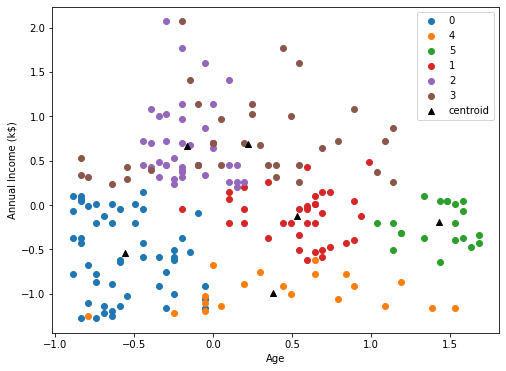

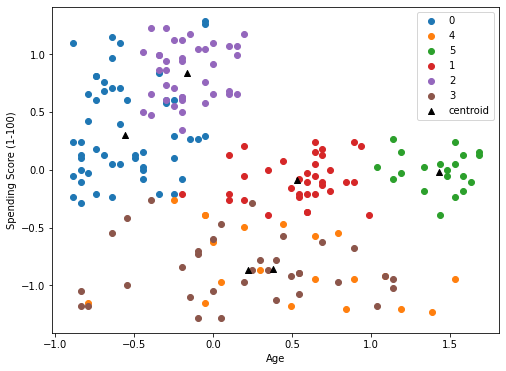

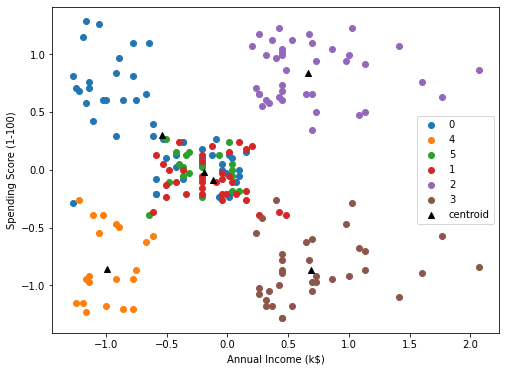

In [19]:
Plot2DCluster(X_Scaled.columns,ClusterDF)

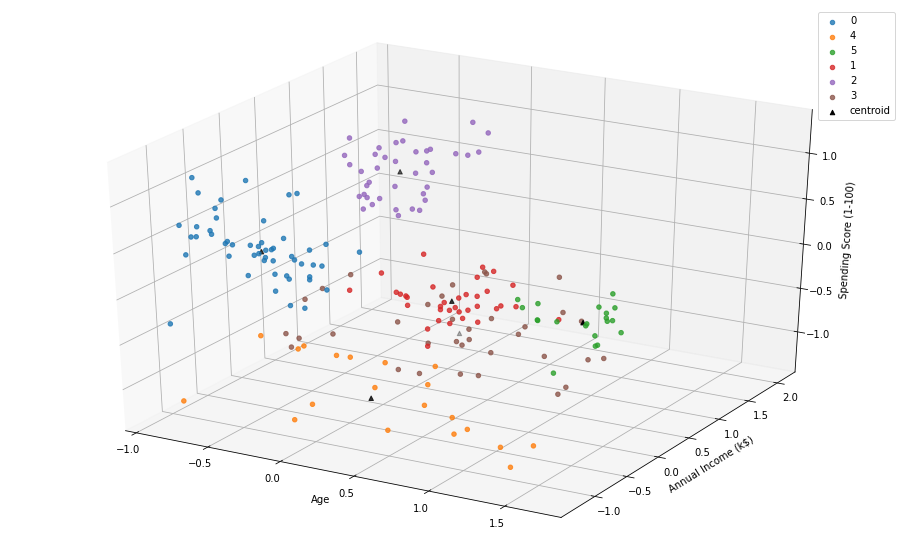

In [20]:
Plot3DCluster(X_Scaled.columns,ClusterDF)

In [21]:
Plotly3D(X_Scaled.columns,ClusterDF)

#### Creator: Ayush Gupta , Github: [Profile](https://github.com/guptayush179)
